In [1]:
# TIRF background
# https://www.microscopyu.com/techniques/fluorescence/total-internal-reflection-fluorescence-tirf-microscopy
# https://www.leica-microsystems.com/science-lab/life-science/total-internal-reflection-fluorescence-tirf-microscopy/
# Tables of fluorochromes https://www.bu.edu/flow-cytometry/files/2013/06/Fluorochromes-Brightness-Chart.pdf
# Tool to visualize colour of fluorochromes https://www.fpbase.org/spectra/
# To open nd2 files import nd2
# Images should be 1606 X 1606
PATH_TO_DATA = '/vol/bitbucket/osella/TIRF/TIRF/data/'
#import nd2
import numpy as np
from skimage.feature import peak_local_max
from scipy import ndimage 
import matplotlib.pyplot as plt
import cv2
# path to data - you can set this as an environment variable
import os, sys
sys.path.append(PATH_TO_DATA)
import nd2
img = nd2.imread(PATH_TO_DATA + '/set1/100xdiluted_10T_200msdelay_1_bsa_500ms.nd2')
from pims import ND2_Reader
frames = ND2_Reader(PATH_TO_DATA + "/set1/100xdiluted_10T_200msdelay_1_bsa_500ms.nd2")
from skimage import morphology
from skimage import segmentation
print(frames.shape)
print(img.shape)

# frames[82]  # display frame 82
# We think it's 30 frames times 2 channels (red and green)
#There is a green channel and a red channel (a filter splits the light to red and green and it's fed into 2 cameras)
#Each channel is the result of exciting using an appropriate laser
# The DNA is orange (so in the red channel) and green is negative control
# Each nanostructure can contain 10 or so tags (this corresponds to 10T in the file name)
# Currently we can detect 2 tags, and can probably do 4 by manually replacing the filter. To go higher we have to 
sumImage = sum([frames[i] for i in range(len(frames)) if i%2 == 0])
print(frames.shape)
sumImage.shape
newImage = sum([frames[i] for i in range(len(frames)) if i%2 == 1])
newImage
img = frames[1]
plt.hist(img.flatten(), bins = 1000)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
#Normalize image - do we need it ?
minimumValue = 0
maximumValue = 1
normalizedImage =  cv2.normalize(img, None, minimumValue, maximumValue, cv2.NORM_MINMAX)

: 

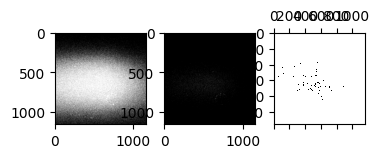

In [2]:

#Otsu's Thresholding
"""
def perform_otsu_threshlding(image):
    #image_norm = tools_read_images.normalize_image(image, max_val=255)
    a, image_thresh = cv2.threshold(image_norm.astype(np.uint8), 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_thresh

def perform_multi_otsu_threshlding(image, num_classes = 4, num_bins = 256):
    image_norm = tools_read_images.normalize_image(image, max_val=255)
    thresholds = skimage.filters.threshold_multiotsu(image_norm, classes=num_classes, nbins = num_bins)
    thresh = cv2.inRange(image_norm, thresholds[-1], 255)
    return thresh

def refine_thresholding(thresh, kernel_size_erode = 3, kernel_size_dilate = 5):
    kernel_erode = np.ones((kernel_size_erode, kernel_size_erode), np.uint8)
    kernel_dilate = np.ones((kernel_size_dilate, kernel_size_dilate), np.uint8)
    thresh_ref = cv2.erode(thresh, kernel_erode, iterations=1) 
    thresh_ref = cv2.dilate(thresh_ref, kernel_dilate, iterations=1) 
    thresh_ref = cv2.normalize(thresh_ref, None, 0, 1, cv2.NORM_MINMAX)
    return thresh_ref

# origamis
kse_struct_back = 5; ksd_struct_back = 13 #5,13
kse_struct_prot = 2; ksd_struct_prot = 2

thresh_struct_back = perform_otsu_threshlding(corr_img)
thresh_struct_back_ref = refine_thresholding(thresh_struct_back, 
                                                                    kernel_size_erode = kse_struct_back, 
                                                                    kernel_size_dilate = ksd_struct_back)
extracted_structure =  corr_img * thresh_struct_back_ref
plt.figure(figsize=(4,4))
plt.imshow(thresh_struct_back_ref,  cmap = 'gray')

# proteins
thresh_struct_prot = perform_multi_otsu_threshlding(extracted_structure)
thresh_struct_prot_ref = refine_thresholding(thresh_struct_prot, 
                                                                    kernel_size_erode = kse_struct_prot, 
                                                                    kernel_size_dilate = ksd_struct_prot)
extracted_proteins = extracted_structure * thresh_struct_prot_ref
plt.figure(figsize=(4,4))
plt.imshow(thresh_struct_prot_ref,  cmap = 'gray')
"""
#Otsu's Thresholding
a, imageNormalizedThresholded = cv2.threshold(normalizedImage.astype(np.uint8), 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
a, imageNonNormalizedThresholded = cv2.threshold(img.astype(np.uint8), 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
figOtsu, axOtsu = plt.subplots(nrows = 1, ncols = 3, figsize=(4,4))
from matplotlib.colors import LogNorm
from pylab import figure, cm
axOtsu[0].imshow(imageNonNormalizedThresholded,  cmap = 'gray')
axOtsu[1].imshow(imageNormalizedThresholded,  cmap = 'gray')
axOtsu[2].matshow(imageNormalizedThresholded, cmap=cm.gray_r, norm=LogNorm(vmin=0.01, vmax=1))

In [3]:
# Segmentation using segment anything needs stills, can't handle a time axis
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
# Load the segment anything model
sam = sam_model_registry["vit_h"](checkpoint="/vol/bitbucket/osella/samCheckpoints/sam_vit_h_4b8939.pth")
sam.to('cuda')

# Generate the mask generator
mask_generator = SamAutomaticMaskGenerator(sam,
                                           points_per_side=32,
                                           points_per_batch=64,
                                           pred_iou_thresh = 0.5,
                                           crop_nms_thresh = 0.2,
                                           crop_n_layers=2)


/vol/bitbucket/osella/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
img = nd2.imread(PATH_TO_DATA + '/set1/100xdiluted_10T_200msdelay_5_bsa_500ms.nd2')

print(f"Shape of frames: {img.shape}")
#imageForSam = np.apply_along_axis(np.sum,0,img)
imageForSam = np.sum(img, axis = 0)
#imageForSam = np.sum(img, axis = 0)
# Change axes so that sam doesn't complain ...
#imageForSam = np.einsum("ijk->jki", imageForSam)
print(f"Shape of imageForSame: {imageForSam.shape}")
imageForSam = np.sum(imageForSam, axis = 0)
print(f"Shape of imageForSame: {imageForSam.shape}")
# Can't imshow the new rearranged image
#plt.imshow(imageForSam )
print(np.max(imageForSam))
print(np.min(imageForSam))
print(imageForSam.dtype)
imageForSam = imageForSam.astype(np.uint8)
print(imageForSam.dtype)
#Resize image
imageForSam = cv2.resize(imageForSam, (1024, 1024))
imageForSam.shape


Shape of frames: (30, 2, 1160, 1160)
Shape of imageForSame: (2, 1160, 1160)
Shape of imageForSame: (1160, 1160)
40117
7067
uint64
uint8


(1024, 1024)

In [10]:
# Test that sam works on something known:
#image = cv2.imread('/vol/bitbucket/osella/neo_project/Data/bow-tie-mica-liquid-JPK-HighSpeed/Images/control bow tie 50 hz 250 pixels and 500nm-2017.12.01-10.42.48.097.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(imageForSam, cv2.COLOR_BGR2RGB)
# Segmentation with sam2
masks_rect = mask_generator.generate(image)

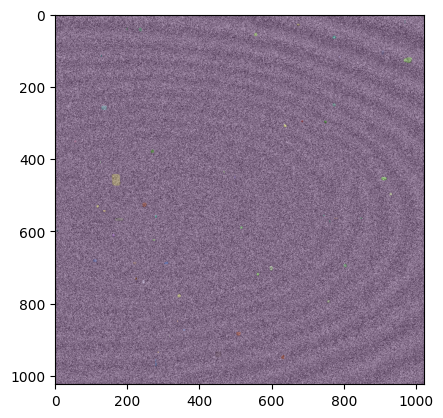

In [11]:
# Show the masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.show()
plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap = 'gray')
show_anns(masks_rect)